<a href="https://colab.research.google.com/github/Praneetha-NM/Wavelet-Based-Contourlet-Coding/blob/main/Dc_Package_Wavelet_Based_Contourlet_Coding_Using_SPIHT_Like_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets
!pip install scipy
!pip install matplotlib

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.transform import resize

In [ ]:
# Perform wavelet decomposition on an image to get its sub-bands
def wavelet_decomposition(image, wavelet='haar', levels=3):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=levels)
    return coeffs

In [ ]:
def directional_filter_bank():
    filters = {
        "horizontal": np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]),
        "vertical": np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]),
        "diagonal": np.array([[2, -1, 0], [-1, 2, -1], [0, -1, 2]])
    }
    return filters

In [ ]:
# Apply directional filters to an image and return the results in a dictionary
def apply_directional_filter(image, filter_bank):
    filtered_images = {}
    for direction, filter_matrix in filter_bank.items():
        filtered_image = convolve(image, filter_matrix, mode='reflect')
        filtered_images[direction] = filtered_image
    return filtered_images


In [ ]:
# SPIHT encoder class to perform significance-based encoding
class SPIHT:
    def __init__(self, threshold=0.1):
        self.threshold = threshold

    def encode_with_sot(self, directional_images):
        significant_coefficients = {}
        spatial_orientation_tree = {}

        # Process each level and direction for significant coefficients
        for level in range(len(directional_images)):
            spatial_orientation_tree[level] = {direction: [] for direction in directional_images[level].keys()}

            for direction, image in directional_images[level].items():
                coeffs = image.flatten()
                for coeff in coeffs:
                    if abs(coeff) > self.threshold:
                        spatial_orientation_tree[level][direction].append(coeff)

            for direction in spatial_orientation_tree[level]:
                spatial_orientation_tree[level][direction].sort(key=abs, reverse=True)

        for level in spatial_orientation_tree:
            for direction in spatial_orientation_tree[level]:
                for coeff in spatial_orientation_tree[level][direction]:
                    significant_coefficients[(level, direction, coeff)] = coeff

        return significant_coefficients

In [ ]:
# Wavelet-based contourlet transform combining wavelet and directional filtering
def wavelet_based_contourlet_transform(image, wavelet='haar', levels=3):
    wavelet_coeffs = wavelet_decomposition(image, wavelet=wavelet, levels=levels)
    directional_images = []
    filter_bank = directional_filter_bank()

    for coeff in wavelet_coeffs:
        if isinstance(coeff, tuple):  # Only apply filters to detail coefficients
            detail_images = {}
            for direction in filter_bank.keys():
                detail_images[direction] = apply_directional_filter(coeff[1], filter_bank)[direction]
            directional_images.append(detail_images)

    return wavelet_coeffs[0], directional_images


In [ ]:
# Flatten directional coefficients for repositioning
def reposition_coefficients(directional_images):
    repositioned = []
    for level_images in directional_images:
        repositioned_level = {}
        for direction, image in level_images.items():
            repositioned_level[direction] = image.flatten()
        repositioned.append(repositioned_level)
    return repositioned

In [ ]:
# Reconstruct the image from approximation coefficients and directional detail images
def reconstruct_image(approx_coeff, directional_images):
    reconstructed_images = []

    for level_images in directional_images:
        combined_image = np.zeros_like(list(level_images.values())[0])  # Initialize for combined details

        for direction, coeffs in level_images.items():
            filtered_image = coeffs

            if filtered_image.shape != combined_image.shape:
                filtered_image = resize(filtered_image, combined_image.shape)  # Resize if necessary

            combined_image += filtered_image

        reconstructed_images.append(combined_image)

    reconstructed_image = approx_coeff.copy()  # Start with approximation coefficients

    for level_image in reconstructed_images:
        level_image_resized = resize(level_image, reconstructed_image.shape)
        reconstructed_image += level_image_resized

    return reconstructed_image

In [ ]:
# Load an image and optionally convert it to grayscale
def load_image(image_path, grayscale=False):
    image = plt.imread(image_path)
    if grayscale and len(image.shape) == 3:
        image = np.mean(image, axis=2)
    return image


In [ ]:
# Calculate compression ratio
def calculate_compression_ratio(original_size, compressed_size):
    ratio = original_size / compressed_size
    return f"{original_size} : {compressed_size} (or {ratio:.2f}:1)"

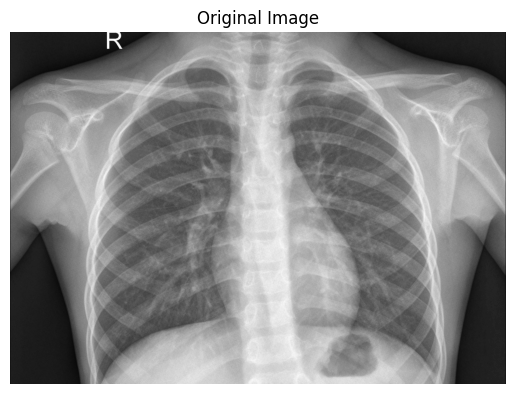

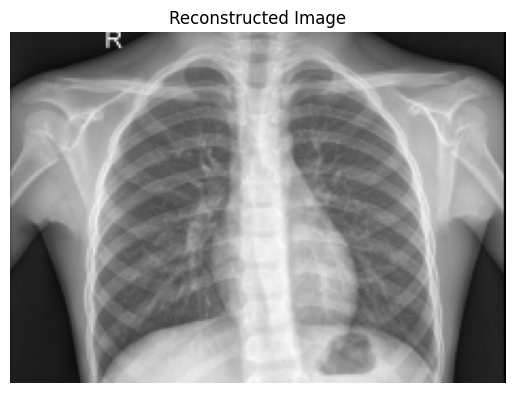

Compression Ratio: 2445669 : 1026520 (or 2.38:1)


In [ ]:
if __name__ == "__main__":

    image_path = '/content/Xray.jpeg'  # Path to the input image
    image = load_image(image_path, grayscale=True)

    original_size = image.nbytes  # Calculate original image size in bytes

    # Perform wavelet-based contourlet transform
    approx, directional_images = wavelet_based_contourlet_transform(image, levels=3)

    # Reposition coefficients for encoding
    repositioned_images = reposition_coefficients(directional_images)

    # Initialize SPIHT encoder and encode significant coefficients
    spiht_encoder = SPIHT(threshold=0.1)
    significant_bits = spiht_encoder.encode_with_sot(repositioned_images)

    compressed_size = len(significant_bits) * 8  # Approximate compressed size in bits

    # Reconstruct the image from transformed coefficients
    reconstructed_image = reconstruct_image(approx, repositioned_images)

    # Display original and reconstructed images
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    plt.imshow(reconstructed_image, cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()

    # Calculate and display compression ratio
    cr = calculate_compression_ratio(original_size, compressed_size)
    print(f"Compression Ratio: {cr}")


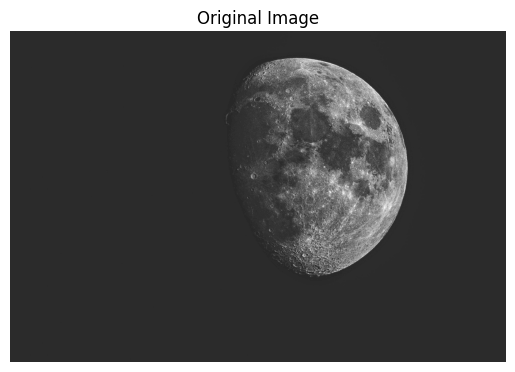

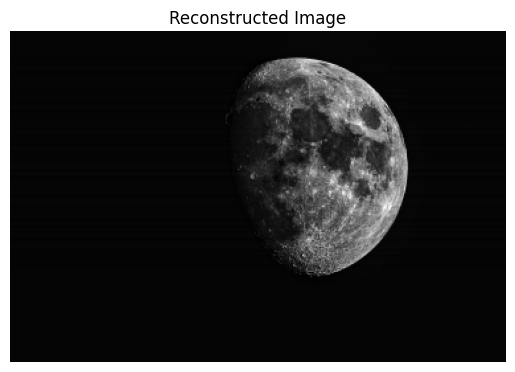

Compression Ratio: 48000000 : 1422184 (or 33.75:1)


In [ ]:
if __name__ == "__main__":

    image_path = '/content/Moon.jpeg'  # Path to the input image
    image = load_image(image_path, grayscale=True)

    original_size = image.nbytes  # Calculate original image size in bytes

    # Perform wavelet-based contourlet transform
    approx, directional_images = wavelet_based_contourlet_transform(image, levels=3)

    # Reposition coefficients for encoding
    repositioned_images = reposition_coefficients(directional_images)

    # Initialize SPIHT encoder and encode significant coefficients
    spiht_encoder = SPIHT(threshold=0.1)
    significant_bits = spiht_encoder.encode_with_sot(repositioned_images)

    compressed_size = len(significant_bits) * 8  # Approximate compressed size in bits

    # Reconstruct the image from transformed coefficients
    reconstructed_image = reconstruct_image(approx, repositioned_images)

    # Display original and reconstructed images
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    plt.imshow(reconstructed_image, cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()

    # Calculate and display compression ratio
    cr = calculate_compression_ratio(original_size, compressed_size)
    print(f"Compression Ratio: {cr}")
